# BSc network analysis

This notebook recreates the network analysis found in the BSc project.

## Theory

The BSc project investigated one network methods:
- Network Flow Matrix: the flow of shoppers between shops

**Network Flow Matrix**

Each shop is a node in the network. The flow of shoppers from one node to another (moving to a different store) is dipicted by the adjacency matrix $A$. Therefore, the number of shoppers going from shop $i$ to shop $j$ is the element $A_{ij}$.

Shopper can both move from shop $i$ to shop $j$ as well as from shop $j$ to shop $i$. We can characterise the `Net Flow`($F$) as the net amount of shoppers moving from $i$ to $j$. Therefore, the `Net Flow` is

$$ F_{ij} = A_{ij} - A_{ji}. $$

Furthermore, the `Net Flow` matrix can also be written as

$$ F_{ij} = A - A^{T}. $$

**Sliding Window**

The devices need to be `binned` to find the number of devices (shoppers) present over a time period at a shop. This is important because the devices emit singals at random intervals which do not allow us to know the exact number of devices in a shop at a given time. So, this will enable the number of shoppers at a particular shop over a given period time to be calculated. The period of time (known as a window) is kept at a fixed width and moved over time at a given rate (known as sliding). Therefore, the number of shopper can be approximated (with a window of 20 minutes) at a 1 minute time interval. This process is known as a `Sliding Window`.

**In-Degree Ranked Distribution**

In-degree $k_{in}$ is the sum of the adjancy matrix elements that direct to a particular shop i:

$$ k_{in}^{(i)} = \sum_{j}A_{ij} $$


## Load dependencies

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2

In [177]:
from msci.utils import utils
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image

## Import raw data

In [6]:
signal_df = utils.import_signals('Mall of Mauritius', version=3, signal_type=1)

## Method

There are two ways to calculate the number of people in each shop and the adjacency matrix:

**Continous counting**
- assume no one is in the store at the beginning of the day
- as you increase the time, a person is in the shop if a signal is recorded from them in that shop
- the person is removed from the store (the count of people in the shop is reduce) if that person produces a signal outside of the shop

Issues:
- if the person disappears from the mall without releasing a final count outside all shops, then the person will not be removed from the last shop they are in and, threrefore, there will be an overestimate of the number of people in that shops in the mall

Things to do:
- find out how many shoppers are left after the store closes in the respective shops to find out if all the shoppers leave / the uncertainty in this method


**Sliding Window**
- use a sliding window to find out how many people are in a given shop between a particular interval
- as you increase the time, if a person is in the produces a signal within a given window of time then count them in the shop but if they don't remove them from the shop (assume people that don't emit signals in the windowed time are not in the store)

Issues:
- the count of people is averaged over a window and not continuously changing when a person arives or leaves (this will give less accurate realtime data & resolution will be the size of the window)
- a device may emit a signal over longer time periods than the window therefore we could class people as having left the shop that are still there (because they haven't emitted a signal in the given timeframe)
- (related to point above) shoppers can disspear from being tracked

Things to do:
- look at histogram of average frequency emitted from a device to determine what the minimum window can be

Potential improvement:
- if there is a signal after in a different location, assume that the person did spend the previous time in between the last signal at the shop which the signal came from

## Result

In [157]:
adjacency_matrix, count_of_shoppers, store_ids_indices, frame_times = \
    create_adjacency_matrices(signal_df, sliding_interval=10, window_size=30)

2016-12-22 07:00:05
2016-12-22 07:10:05
2016-12-22 07:20:05
2016-12-22 07:30:05
2016-12-22 07:40:05
2016-12-22 07:50:05
2016-12-22 08:00:05
2016-12-22 08:10:05
2016-12-22 08:20:05
2016-12-22 08:30:05
2016-12-22 08:40:05
2016-12-22 08:50:05
2016-12-22 09:00:05
2016-12-22 09:10:05
2016-12-22 09:20:05
2016-12-22 09:30:05
2016-12-22 09:40:05
2016-12-22 09:50:05
2016-12-22 10:00:05
2016-12-22 10:10:05
2016-12-22 10:20:05
2016-12-22 10:30:05
2016-12-22 10:40:05
2016-12-22 10:50:05
2016-12-22 11:00:05
2016-12-22 11:10:05
2016-12-22 11:20:05


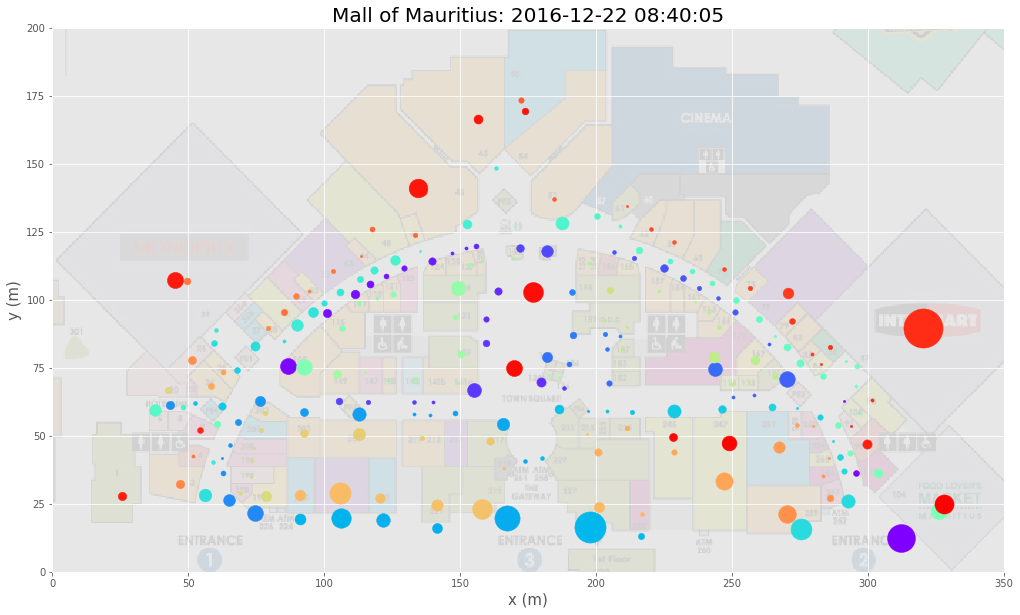

In [178]:
create_count_of_shoppers_image(count_of_shoppers, frame_times)

In [181]:
create_count_of_shoppers_gif(count_of_shoppers, frame_times);

c:\users\tvb\envs\venv-msci\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
